### Loading required liabraries

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels
import seaborn as sns
import datetime
import scipy.stats as stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy.stats as scipy
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from statsmodels.tools.eval_measures import rmse



### Loading and creating DataFrame

In [21]:
df = pd.read_csv('data/salary.csv')
df.head()

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,male,Field,yearsabs
0,53000.0,0,0,0,1.17,1,0,1,1,3,0
1,58000.0,1,0,0,1.24,1,0,1,1,2,0
2,45500.0,0,0,0,1.21,1,0,1,1,3,2
3,35782.0,0,2,1,0.99,1,0,1,1,4,1
4,34731.0,0,2,2,0.91,1,0,1,1,4,1


In [22]:
null_values= df.isnull().sum().sum()
print('Number of missing values is: ',null_values)
null = df[df.salary.isnull()]
null

Number of missing values is:  1


,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,male,Field,yearsabs
208,NaN,0,21,10,0.93,1,0,3,1,4,1


### Filling null value with the mean

In [23]:
df['salary'].fillna(df['salary'].mean(),inplace = True)
df = df.drop_duplicates()



### 1. Splitting the data set to training and testing

In [24]:

train_x, test_x, train_y, test_y = train_test_split(df, df.salary, test_size=0.3, random_state=100)
print(train_x.shape, train_y.shape) 
print( test_x.shape, test_y.shape)


(359, 11) (359,)
(155, 11) (155,)


 - We decided to split my dataset in a 70:30 ratio for taining:testing respectively, since given the size of the dataset, this is the most appropriate ratio to use.


# Hypothesis Testing¶
- Null Hypothesis: There is no relationship that exists between salary and all the features in the dataset.
- Alternate Hypothesis: There exists a linear relationship between salary and some of the features in the dataset.


### Looking at feautures that are highly correlated with salary

In [25]:
data_corr =train_x.corr().iloc[:,0].sort_values()
data_corr

Field         -0.531328
yearsabs      -0.113223
degree         0.047555
otherqual      0.130228
exprior        0.143172
male           0.380671
market         0.416172
yearsrank      0.599571
yearsworked    0.606962
position       0.716896
salary         1.000000
Name: salary, dtype: float64

- From this I can see that position is highly correlated with salary 
- There is a  correlation betwwen salary and years ranked.
- There is a  correlation betwwen salary and years worked.
- There is also a slight negetive correlation between salary and Field

### Validating the effect of the correlation of the above features
- with significance test using p-value

In [26]:
print(f'pvalue of years worked and salary: {stats.pearsonr(df.yearsworked, df.salary)}')
print(f'pvalue of years rank and salary: {stats.pearsonr(df.yearsrank, df.salary)}')
print(f'pvalue of postion and salary: {stats.pearsonr(df.position, df.salary)}')
print(f'pvalue of field and salary: {stats.pearsonr(df.Field, df.salary)}')

pvalue of years worked and salary: (0.6231354820920552, 1.2747795189693407e-56)
pvalue of years rank and salary: (0.610580392524893, 7.841461421302136e-54)
pvalue of postion and salary: (0.7013536954022151, 2.6542174506471035e-77)
pvalue of field and salary: (-0.49848547458371756, 1.2205378378494786e-33)


- The p-value for yearsranked is far less than 0.05, and so we believe that there is a relationship between years ranked and salary. Thus an increase in number of years worked  in your current possition will result in an increase in salary.
- The p-value for yearsworked is far less than 0.05, and so we believe that there is a relationship between years worked and salary. Thus an increase in number of years worked will result in an increase in salary.
- The p-value for position is far less than 0.05, and so we believe that there is a relationship between position and salary. Thus the higher the position,the higher the  salary.
- The p-value for field is far less than 0.05, and so we believe that there is a relationship between field and salary. Thus certain field rank higher than other position so hihg ranked field earn more.

### According to the p-values computed above which are within the threshold for all four variables, we reject the null hypothesis and go on to use years ranked,salary, position, field and years worked as key features to build my model.

## Checking for descriptive statistics table

In [27]:
df_new = train_x[['salary','yearsworked', 'yearsrank','position','Field']]


In [28]:
df_new.describe()

,salary,yearsworked,yearsrank,position,Field
count,359.000000,359.000000,359.000000,359.000000,359.000000
mean,51607.590936,13.206128,7.217270,2.178273,2.495822
std,12607.848642,9.504005,6.341548,0.816366,1.120833
min,29000.000000,0.000000,0.000000,1.000000,1.000000
25%,40512.000000,4.000000,2.000000,1.000000,1.000000
50%,52172.000000,12.000000,5.000000,2.000000,3.000000
75%,61065.500000,22.000000,12.000000,3.000000,3.000000
max,96156.000000,35.000000,24.000000,3.000000,4.000000


### Creating Histograms for the variables of interest

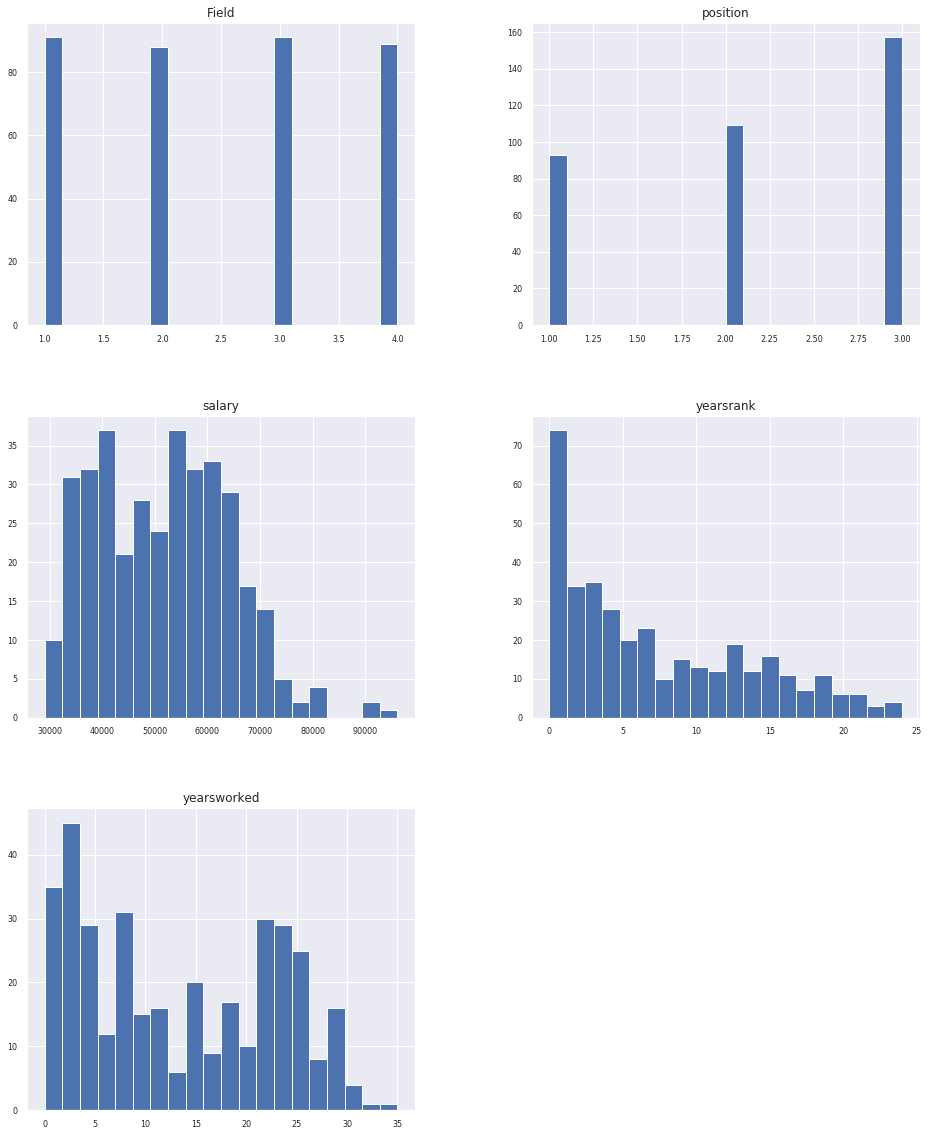

In [29]:
sns.set()
df_new.hist(figsize=(16, 20),bins=20, xlabelsize=8, ylabelsize=8);

## From the above histograms of the features of interest it is clear that Position and Field are categorical data.

 ### Salary
- There are few possible outliers
- The distribution is skewed to the right
- A lot of individuals earn between 33000 dollars & 75000 dollars
### Years worked in this field
- There are possible outliers 
- The distribution is skewed to the right
- A lot of individuals have worked between 0 years & 29 years
### Years worked at current rank
- The distribution is skewed to the right
- There are possible outliers just few of them
- Most individuals have worked at the current rank for years between 0 & 5 years.

### 2.One-hot encode the variable Field into four dummy variables, using HR as the reference category.

In [30]:
field = pd.get_dummies(df['Field'])
position = pd.get_dummies(df['position'])

new_field = field.rename(columns={1:'Engeneering',2:'Finance',3:'HR',4:'Marketing'})
new_position = position.rename(columns={1:'Junior_Employee', 2: 'Manager', 3:'Executive'})

salary = pd.concat([df, new_field, new_position] ,axis=1)
salary.drop(['position','Field'], axis=1,inplace=True)
salary.head()

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,male,yearsabs,Engeneering,Finance,HR,Marketing,Junior_Employee,Manager,Executive
0,53000.0,0,0,0,1.17,1,0,1,0,0,0,1,0,1,0,0
1,58000.0,1,0,0,1.24,1,0,1,0,0,1,0,0,1,0,0
2,45500.0,0,0,0,1.21,1,0,1,2,0,0,1,0,1,0,0
3,35782.0,0,2,1,0.99,1,0,1,1,0,0,0,1,1,0,0
4,34731.0,0,2,2,0.91,1,0,1,1,0,0,0,1,1,0,0


### 3.Checking for Multicolinearity

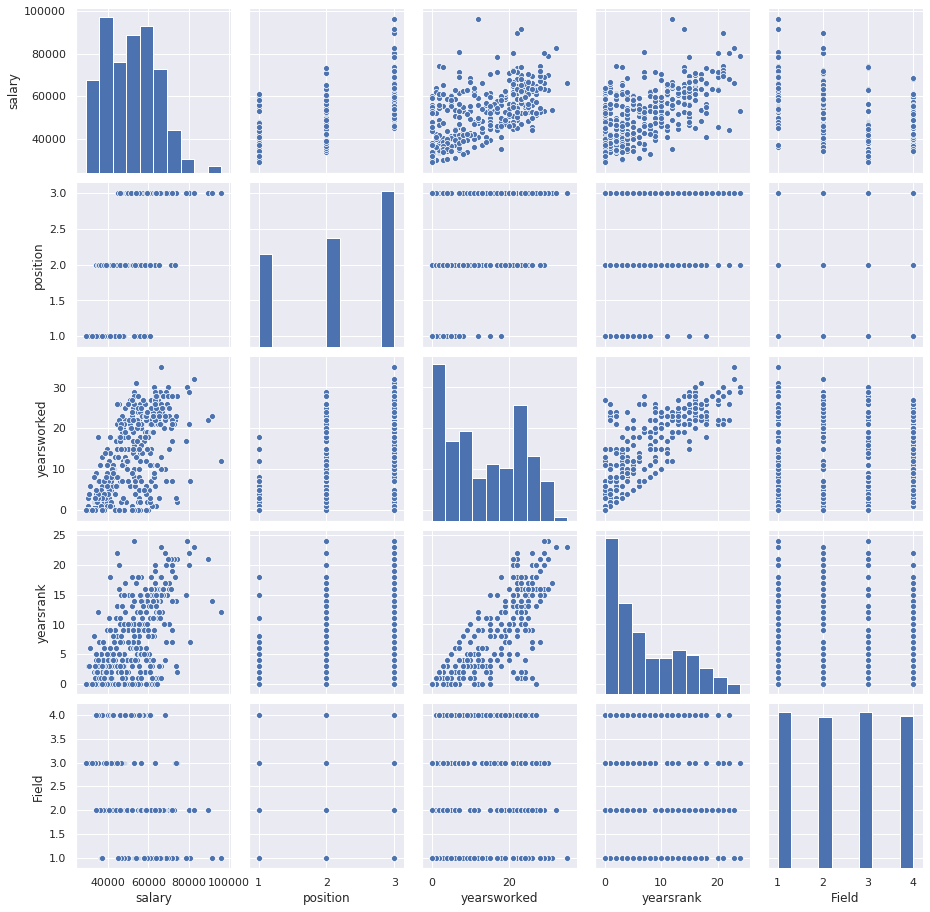

In [31]:
sns.pairplot(df_new[['salary', 'position','yearsworked','yearsrank','Field']])

- After oberving the above charts, there seem to be a linear relationship among yearsworked and years rank, thus there is multicolinearity, Therefore we are selecting one variables with the most correlation between those two as our predictors for the target salary. We will also be selecting position and field as predictors also.

## 4.Model development

### Fitting the model for the desired features

In [32]:
X = sm.add_constant(train_x[['yearsworked','position','Field']])
model = sm.OLS(train_y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     198.2
Date:                Wed, 15 Apr 2020   Prob (F-statistic):           1.69e-75
Time:                        11:27:45   Log-Likelihood:                -3722.0
No. Observations:                 359   AIC:                             7452.
Df Residuals:                     355   BIC:                             7468.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4.149e+04   1788.675     23.194      0.000     3.8e+04     4.5e+04
yearsworked   179.8843     65.103      2.763      0.006      51.848     307.921
position     7877.8514    769.532     10.237      0.000    6364.437    9391.266
Field       -3772.1710    384.874     -9.801      0.000   -4529.090   -3015.252
==============================================================================
Omnibus:                       55.930   Durbin-Watson:                   1.830
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               91.138
Skew:                           0.929   Prob(JB):                     1.62e-20
Kurtosis:                       4.624   Cond. No.                         76.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- According to the model above:
- 62.6% of the variation in salary is due to years worked,field and position, the Dublin-Watson score of 1.830 indicates no autocorrelation among the key features

In [33]:
model.params

const          41486.571925
yearsworked      179.884253
position        7877.851443
Field          -3772.171033
dtype: float64

### 5.Compute the standardised residuals (resid()) and standardised predicted values (fittedvalues()).¶


In [34]:
#Create residuals
residual  = model.resid

#Fit linear model to dataset
results   = model.fittedvalues


#create instance of influence
influence = model.get_influence()

#leverage (hat values)
leverage = influence.hat_matrix_diag

#Cook's D values and p-values
cooks_d = influence.cooks_distance

#standardized residuals(internal)
standardized_residuals = influence.resid_studentized_internal

#standardized residuals(external)
studentized_residuals = influence.resid_studentized_external

In [35]:

#Representing residuals and fitted values in a table

residuals_fitted = {'Residual': residual, 'Standard_residual':studentized_residuals, 'Predicted Salary': results, 'Actual Salary' :train_y}


residuals_fitted = pd.DataFrame(residuals_fitted)

residuals_fitted.head()

,Residual,Standard_residual,Predicted Salary,Actual Salary
477,-9050.025502,-1.172170,48624.025502,39574.00000
75,-5342.182974,-0.691805,46825.182974,41483.00000
462,4201.649733,0.546969,36434.350267,40636.00000
254,8388.659249,1.087262,61713.122001,70101.78125
84,-8160.951480,-1.056951,47184.951480,39024.00000


###  6.Plot of residuals versus the predicted values  with fitted values as the x parameter, and the dependent variable as y, specifying lowess=True

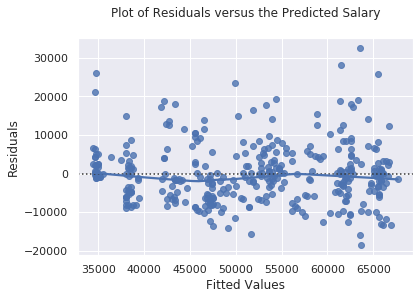

In [36]:
sns.residplot(x = results, y = residual, lowess=True)

plt.title('Plot of Residuals versus the Predicted Salary\n')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals');

###  Predictions

In [39]:
#Run model on the test set
test_x = sm.add_constant(test_x[['yearsworked','position','Field']])

y_prediction = model.predict(test_x)

pred = model.predict(X)

### Model quality check

In [40]:
# Train
training_rmse = rmse(train_y, pred)
training_rmse
# Test
testing_rmse = rmse(test_y, y_prediction)
testing_rmse
diffrence  = testing_rmse - training_rmse
print(f'The difference between train and test: {diffrence}')


The difference between train and test: 933.556834498916



#### The RMSE scores show no signs of overfitting or underfitting. The test is higer than the train values which makes sense since it has less data than the training set.The model seems to be a good model since it has satisfied the linear regression assumption.

###### Linear regression assumptions:
- Linear relationship
- Multivariate normality
- No multicollinearity
- No auto-correlation


### conclusion


- The accuracy of the model has proved that Years Worked and Position are strong predictors for employee's salary